##### データセットの場所やバッチサイズなどの定数値の設定

In [13]:
import os
import torch
from path import Path

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'


# 使用するデバイス
# GPU を使用しない環境（CPU環境）で実行する場合は DEVICE = 'cpu' とする
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

# 全ての訓練データを一回ずつ使用することを「1エポック」として，何エポック分学習するか
N_EPOCHS = 30

# 学習時のバッチサイズ
BATCH_SIZE = 64

# 訓練データセット（画像ファイルリスト）のファイル名
TRAIN_DATASET_CSV = '../defacto/train_list.csv'

# テストデータセット（画像ファイルリスト）のファイル名
TEST_DATASET_CSV = '../defacto/test_list.csv'

# 画像ファイルの先頭に付加する文字列（データセットが存在するディレクトリのパス）
DATA_DIR = '../defacto'

# 画像サイズ
H = 128 # 縦幅
W = 128 # 横幅
C = 3 # 入力画像のチャンネル数（カラー画像なら3，グレースケール画像なら1．なお，正解のマスク画像のチャンネル数は常に1）

# 学習結果の保存先フォルダ
MODEL_DIR = '../defacto_models'

# 学習結果のニューラルネットワークの保存先
MODEL_SAVE = True
MODEL_FILE = os.path.join(MODEL_DIR, 'forgery_detector_model.pth')

# テスト処理結果の保存先フォルダ
RESULTS_DIR = '../defacto_models_results'

if not os.path.isdir(MODEL_DIR):
    Path(MODEL_DIR).makedirs_p()
if not os.path.isdir(RESULTS_DIR):
    Path(RESULTS_DIR).makedirs_p()

cuda:0


##### ニューラルネットワークモデルの定義

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# 畳込み，バッチ正規化，ReLUをセットで行うクラス
class myConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(myConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


# 逆畳込み，バッチ正規化，ReLUをセットで行うクラス
class myConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(myConvTranspose2d, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


# defacto の画像中から改ざん領域を推定するニューラルネットワーク
class ForgeryDetector(nn.Module):

    # C: 入力画像のチャンネル数（1または3と仮定）
    # H: 入力画像の縦幅（8の倍数と仮定）
    # W: 入力画像の横幅（8の倍数と仮定）
    def __init__(self, C, H, W):
        super(ForgeryDetector, self).__init__()

        # 畳込み層1
        # カーネルサイズ3，ストライド幅1，パディング1の設定なので，これを通しても特徴マップの縦幅・横幅は変化しない
        self.conv1 = myConv2d(in_channels=C, out_channels=16, kernel_size=3, stride=1, padding=1)

        # 畳込み層2～4
        # カーネルサイズ4，ストライド幅2，パディング1の設定なので，これらを通すことにより特徴マップの縦幅・横幅がそれぞれ 1/2 になる
        # 3つ適用することになるので，最終的には都合 1/8 になる -> ゆえに，入力画像の縦幅と横幅を各々8の倍数と仮定している
        self.conv2 = myConv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = myConv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv4 = myConv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)

        # 逆畳込み層5～7
        # カーネルサイズ4，ストライド幅2，パディング1の設定なので，これらを通すことにより特徴マップの縦幅・横幅がそれぞれ 2 倍になる
        # 3つ適用することになるので，最終的には元の大きさに戻る
        self.deconv5 = myConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.deconv6 = myConvTranspose2d(in_channels=128, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.deconv7 = myConvTranspose2d(in_channels=64, out_channels=16, kernel_size=4, stride=2, padding=1)

        # 畳込み層8
        # カーネルサイズ3，ストライド幅1，パディング1の設定なので，これを通しても特徴マップの縦幅・横幅は変化しない
        self.conv8 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)
        h4 = self.conv4(h3)
        h = self.deconv5(h4)
        h = torch.cat([h, h3], dim=1) # U-net 型の skip connection
        h = self.deconv6(h)
        h = torch.cat([h, h2], dim=1) # U-net 型の skip connection
        h = self.deconv7(h)
        h = torch.cat([h, h1], dim=1) # U-net 型の skip connection
        y = torch.sigmoid(self.conv8(h))
        return y

##### 性能評価のための関数の定義

In [15]:
import torch


# 二枚の白黒画像の一致度を調べる
def region_consistency_metric(estimated, gt, threshold=0.2):

    def ratio(a, b):
        indices = b.nonzero()
        if len(indices) == 0:
            return 0
        else:
            return float(torch.mean(a[indices] / b[indices]))

    one = torch.ones(gt.size()).to(gt.device)
    zero = torch.zeros(gt.size()).to(gt.device)
    gt = torch.where(gt > threshold, one, zero)
    estimated = torch.where(estimated > threshold, one, zero)
    intersection = estimated * gt
    union = estimated + gt
    union = torch.where(union > 1, one, union)
    E = torch.sum(estimated, dim=(1, 2, 3))
    G = torch.sum(gt, dim=(1, 2, 3))
    I = torch.sum(intersection, dim=(1, 2, 3))
    U = torch.sum(union, dim=(1, 2, 3))
    recall = ratio(I, G)
    precision = ratio(I, E)
    iou = ratio(I, U)

    return recall, precision, iou

##### 訓練データセットの読み込み

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from mylib.data_io import CSVBasedDataset


# CSVファイルを読み込み, 訓練データセットを用意
dataset = CSVBasedDataset(
    filename = TRAIN_DATASET_CSV,
    items = [
        'Input Image', # X
        'Ground Truth' # Y
    ],
    dtypes = [
        'image', # Xの型
        'image'  # Yの型
    ],
    dirname = DATA_DIR
)

# 訓練データセットを分割し，一方を検証用に回す
dataset_size = len(dataset)
valid_size = int(0.01 * dataset_size) # 全体の 1% を検証用に
train_size = dataset_size - valid_size # 残りの 99% を学習用に
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 訓練データおよび検証用データをミニバッチに分けて使用するための「データローダ」を用意
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

##### 学習処理の実行

Epoch 1:


  0%|          | 0/310 [00:00<?, ?it/s]

100%|██████████| 310/310 [00:21<00:00, 14.42it/s]


train loss = 0.268922


100%|██████████| 4/4 [00:00<00:00, 21.95it/s]


valid loss = 0.270811
recall = 0.310541
precision = 0.300905
IoU = 0.131476



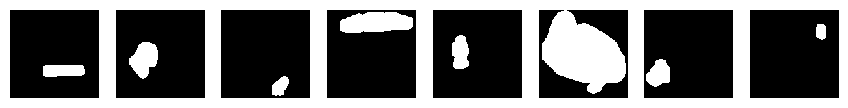

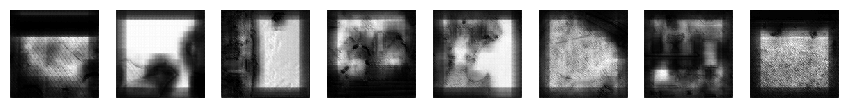

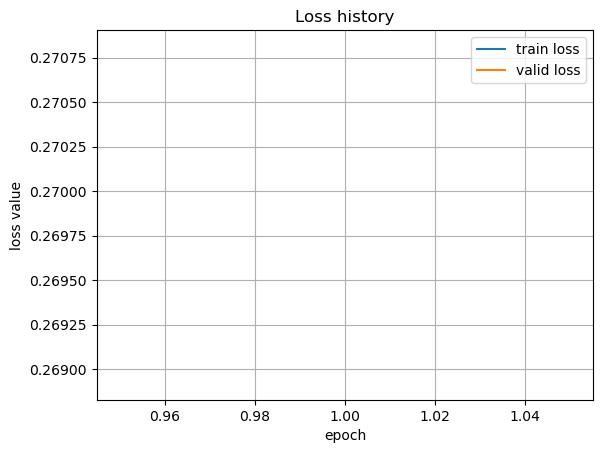

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from mylib.visualizers import LossVisualizer
from mylib.data_io import show_images


# ニューラルネットワークの作成
model = ForgeryDetector(C=C, H=H, W=W).to(DEVICE)

# 最適化アルゴリズムの指定（ここでは SGD でなく Adam を使用）
optimizer = optim.Adam(model.parameters())

# 損失関数
loss_func = nn.BCELoss()

# 損失関数値を記録する準備
loss_viz = LossVisualizer(['train loss', 'valid loss'])

# 勾配降下法による繰り返し学習
for epoch in range(N_EPOCHS):

    print('Epoch {0}:'.format(epoch + 1))

    # 学習
    model.train()
    sum_loss = 0
    for X, Y in tqdm(train_dataloader):
        for param in model.parameters():
            param.grad = None
        X = X.to(DEVICE) # 入力画像
        Y = Y.to(DEVICE) # 正解のマスク画像
        Y_pred = model(X) # 入力画像 X をニューラルネットワークに入力し，改ざん領域の推測値 Y_pred を得る
        loss = loss_func(Y_pred, Y) # 損失関数の現在値を計算
        loss.backward() # 誤差逆伝播法により，個々のパラメータに関する損失関数の勾配（偏微分）を計算
        optimizer.step() # 勾配に沿ってパラメータの値を更新
        sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / train_size
    loss_viz.add_value('train loss', avg_loss) # 訓練データに対する損失関数の値を記録
    print('train loss = {0:.6f}'.format(avg_loss))

    # 検証
    model.eval()
    sum_loss = 0
    sum_recall = 0
    sum_precision = 0
    sum_IoU = 0
    with torch.inference_mode():
        for X, Y in tqdm(valid_dataloader):
            X = X.to(DEVICE) # 入力画像
            Y = Y.to(DEVICE) # 正解のマスク画像
            Y_pred = model(X)
            loss = loss_func(Y_pred, Y)
            recall, precision, IoU = region_consistency_metric(Y_pred, Y) # 評価指標の値を計算
            sum_recall += recall * len(X)
            sum_precision += precision * len(X)
            sum_IoU += IoU * len(X)
            sum_loss += float(loss) * len(X)
    avg_recall = sum_recall / valid_size
    avg_precision = sum_precision / valid_size
    avg_IoU = sum_IoU / valid_size
    avg_loss = sum_loss / valid_size
    loss_viz.add_value('valid loss', avg_loss) # 検証用データに対する損失関数の値を記録
    print('valid loss = {0:.6f}'.format(avg_loss))
    print('recall = {0:.6f}'.format(avg_recall))
    print('precision = {0:.6f}'.format(avg_precision))
    print('IoU = {0:.6f}'.format(avg_IoU))
    print('')

    # 学習経過の表示
    if epoch == 0:
        show_images(Y.to('cpu').detach(), num=8, num_per_row=8, title='ground truth', save_fig=False, save_dir=MODEL_DIR)
    show_images(Y_pred.to('cpu').detach(), num=8, num_per_row=8, title='epoch {0}'.format(epoch + 1), save_fig=False, save_dir=MODEL_DIR)

if MODEL_SAVE:
    # 学習結果のニューラルネットワークモデルをファイルに保存
    model = model.to('cpu')
    torch.save(model.state_dict(), MODEL_FILE)

    # 損失関数の記録をファイルに保存
    loss_viz.save(v_file=os.path.join(MODEL_DIR, 'loss_graph.png'), h_file=os.path.join(MODEL_DIR, 'loss_history.csv'))

##### 学習済みニューラルネットワークモデルのロード

In [18]:
import torch


# ニューラルネットワークモデルとその学習済みパラメータをファイルからロード
model = ForgeryDetector(C=C, H=H, W=W)
model.load_state_dict(torch.load(MODEL_FILE))

<All keys matched successfully>

##### テストデータセットの読み込み

In [19]:
from torch.utils.data import DataLoader, random_split
from mylib.data_io import CSVBasedDataset

# CSVファイルを読み込み, テストデータセットを用意
test_dataset = CSVBasedDataset(
    filename = TEST_DATASET_CSV,
    items = [
        'Input Image', # X
        'Ground Truth' # Y
    ],
    dtypes = [
        'image', # Xの型
        'image'  # Yの型
    ],
    dirname = DATA_DIR,
)
test_size = len(test_dataset)

# テストデータをミニバッチに分けて使用するための「データローダ」を用意
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

##### テスト処理

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


recall = 0.264259
precision = 0.253482
IoU = 0.110632



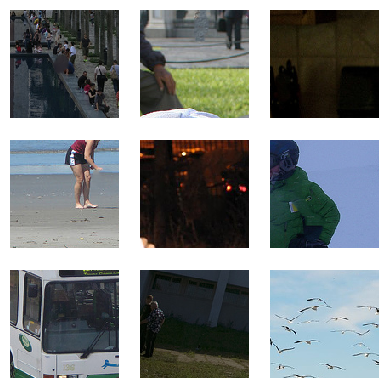

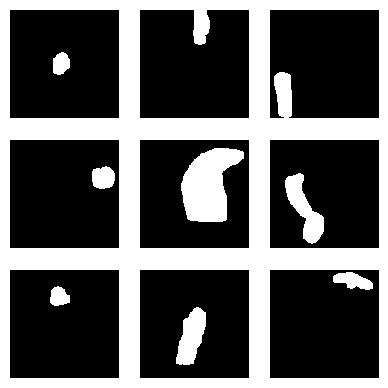

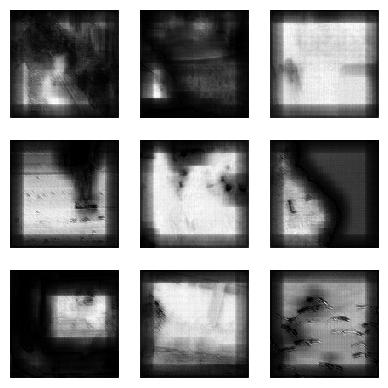

In [20]:
import torch
from tqdm import tqdm
from mylib.data_io import show_images

#テスト用パラメータ##
SEED = 0 # 最後に出力する画像
out_size = 9 # 16枚を読みだす
out_row = 3 # 最後に画像を何行で表示するか
####################


# 推定結果の例に使用する画像の取り出し
torch.manual_seed(SEED)
out_dataset, _ = random_split(test_dataset, [out_size, test_size - out_size])
out_dataloader = DataLoader(out_dataset, batch_size=out_size, shuffle=False, pin_memory=False)
out_iter = iter(out_dataloader)


model = model.to(DEVICE)
model.eval()


# テストデータセットで精度を評価
sum_recall = 0
sum_precision = 0
sum_IoU = 0
with torch.inference_mode():
    for X, Y in tqdm(test_dataloader):
        X = X.to(DEVICE) # 入力画像
        Y = Y.to(DEVICE) # 正解のマスク画像
        Y_pred = model(X)
        recall, precision, IoU = region_consistency_metric(Y_pred, Y)
        sum_recall += recall * len(X)
        sum_precision += precision * len(X)
        sum_IoU += IoU * len(X)
avg_recall = sum_recall / test_size
avg_precision = sum_precision / test_size
avg_IoU = sum_IoU / test_size
print('recall = {0:.6f}'.format(avg_recall))
print('precision = {0:.6f}'.format(avg_precision))
print('IoU = {0:.6f}'.format(avg_IoU))
print('')


# 推定結果の例を表示
X, Y = next(out_iter)
X = X.to(DEVICE) # 入力画像
Y = Y.to(DEVICE) # 正解のマスク画像
Y_pred = model(X)
show_images(X.to('cpu').detach(), num=out_size, num_per_row=out_row, title='seed={} input image'.format(SEED), save_fig=True, save_dir=RESULTS_DIR)
show_images(Y.to('cpu').detach(), num=out_size, num_per_row=out_row, title='seed={} ground truth'.format(SEED), save_fig=True, save_dir=RESULTS_DIR)
show_images(Y_pred.to('cpu').detach(), num=out_size, num_per_row=out_row, title='seed={} estimated'.format(SEED), save_fig=True, save_dir=RESULTS_DIR)